# Foreword

In chapter 10, We introduced artificial neural networks and trained shallow network, with just few hidden layers. What if you need to tackle very complex problems, such as detecting hundreds of types of objects in high resolution images? You may need to train a much deeper DNN, perhaps 10 layer or more with 100s of neurons, connected by hundreds, even thousands of connections. 

- First, you need to tackle **vanishing gradients/exploding gradients** problem. This affects DNN and makes lower layers very hard to train. 
- Second, you might not have enough training data for such a large network, or it might be too costly to label. 
- Third, Training will be extremely slow. 
- Fourth, a model with million of parameters would severly risk overfitting the training set, especially if there are not enough training instances, or they are too noisy.

In this chapter, we will go through each of these problems in turn and present techniques to solve them. 


## Vanishing/Exploding Gradients

The backprop algorithm works by going from output layer to the input layer, propagating the error gradient on the way. Once the algorithm has computed the gradient of the cost function with regards to each parameter in the network, it uses these gradients to update each parameter with a Gradient Descent step. 

Unfortunately, Gradient gets smaller and smaller as the algorithm progresses down to the layers. Due to which Gradient Descent update leaves the lower layer connection weights virtually unchanged, and training never converges to a good solution. This is called **Vanishing Gradient** problem. 

Similarly, the opposites can happen, the gradients grow bigger and bigger, so man layers get insanely large weight updates and the algorithm diverges. This is called **exploding gradient** problem. 

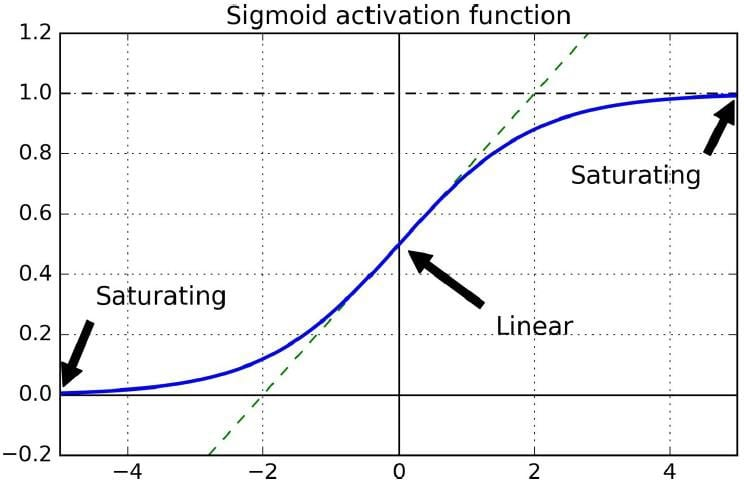

In [2]:
from IPython import display
display.Image("https://www.simplilearn.com/ice9/free_resources_article_thumb/gradients-in-sigmoid-activation-functions.jpg")

Looking at the logistic activation function above, we can see that when inputs become large (negative or positive), the function saturates to 0 or 1, with a derivative close to 0. Thus when backpropagation kicks in, it has virtually no gradient to propagate back through the network, and what little gradient exists keep getting diluted as backprop progresses down through the top layer. 

## Glorot and He Initialization.
In Glorot paper, they propose a way to significantly alleviate this problem. 
- We need signal to flow properly in both directions: forward and backward, and we don't want signal to die out, nor do we want it to explode or saturate. 
- For the signal to flow properly, author argue that we need the variance of outputs of each layer to be equal to the variance of its inputs. And we also need the gradients to have equal variance before and after flowing through a layer in reverse direction. It's not possible to gurantee both unless the later has an equal number of inputs and neurons (these are *fan-in* and *fan-out* of the layer. 
- The paper proposes a compromise that has proven to work very well in practice: the connection weights of each layer must be initialized randomly as described in equation below where $fan_{avg} = (fan_{in} + fan_{out}) / 2$. This initialization is called **Xavier initialization**. 

Normal distribution with mean 0 and variance $\sigma^2 = \frac{1}{fan_{avg}}$

Or a Uniform distribution between -r and +r, with r = $\sqrt\frac{3}{fan_{avg}}$

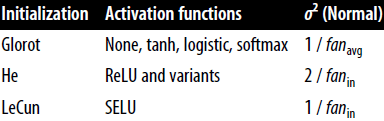

In [4]:
display.Image("https://i2.wp.com/img-blog.csdnimg.cn/20200624082145939.png")

The initialization parameters for each type of activation function is shown above. 


By default, keras use glorot initialization with a uniform distribution. You can change this to He initializaiton by setting *kernel_initializer = "he_uniform"* or *kernel_initializer = "he_normal"* when creating a layer like this:   
```keras.layers.Dense(10,activation = "relu",kernel_initializer = "he_normal"```

## Nonsaturating Activation Functions

Insights from glorot paper suggested that vanishing/exploding gradient problem we in part due to poor choice of activation function. It turns out other activation function such as ReLU works better in deep neural networks, because it doesn't saturate for positive values. 

But ReLU activation function suffers from a problem called *dying ReLU*: during training, some neurons effectively die, meaning they stop outputting anything other than 0. A neuron dies when its weights get tweaked in such a way that the weighted sum of its inputs are negative for all instances in training set. When this happens, it just keeps outputting 0s and gradient descent doesn't affect it anymore since the gradient of ReLU function is 0 when its input is negative. 

To solve this problem, *leaky ReLU* comes into action. 

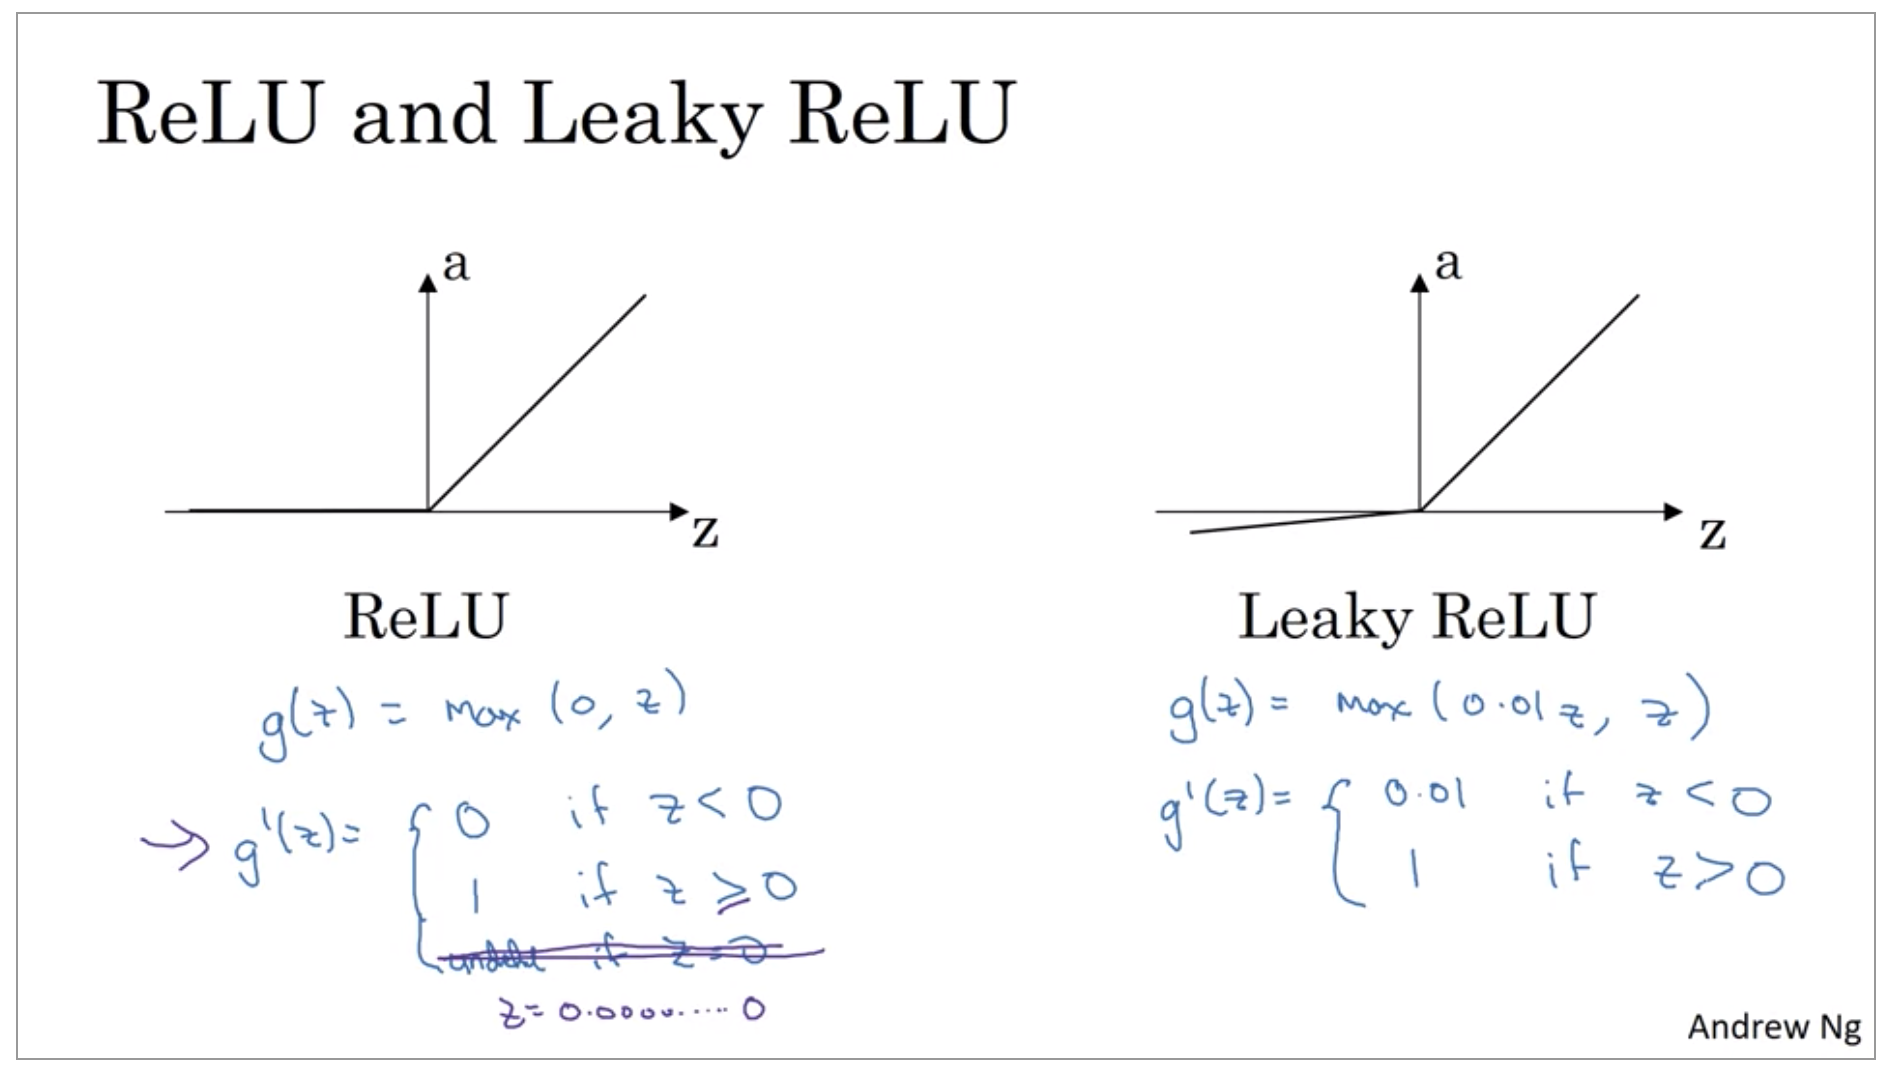

In [7]:
display.Image("https://hackerwins.github.io/assets/img/2019-08-19-dls-c1-week3/relu-and-leaky-relu.png")

To use leaky relu, you must create a LeakyReLU instance:  

``` leaky_relu = keras.layers.LeakyReLU(alpha = 0.2)```  

``` layer = keras.layers.Dense(10,activation = leaky_relu,kernel_initializer = "he_normal"```


## Batch Normalization

Although using He initialization along with any variants of ReLU can significantly reduce vanishing/exploding gradients problems at the beginning of training, it doesn't gurantee that they won't come back during training. 

A proposed technique in a 2015 paper is called *Batch Normalization* to address vanishing/exploding gradients problem. The technique consists of adding an operation in the model just before or after the activation function of each hidden layer, simply zero-centering and normalizing each input, then scaling and shifting the result using two new parameter vector per layer: one for scaling and other for shifting. 

Inorder to zero-center and normalize the inputs, the algorithm needs to estimate each input's mean and standard deviation. It does so by evaluating mean and standard deviation of each input over the current mini-batch (hence **Batch Normalization**)

Let's say input batch has *batch_inputs* data. then, 

- Mean = mean(batch_inputs)

- std = std(batch_inputs) 

- new_batch_inputs = (batch_inputs - mean) / std

- neuron_output = activation(weights * new_batch_inputs + bias)

So, Batch Normalizaiton just standardizes its inputs then rescales and offsets them. 

### Implementing Batch Normalization using keras.

In [9]:
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import sklearn
import matplotlib.pyplot as plt

In [13]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [10]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1

- Each BN layer adds 4 parameters per input. so, 784 x 4 = 3136 parameters
- Two BN parameter mean and variance, are moving averages, they are not affected by backpropagation, so they are called *non trainable parameters*
- BN parameter = 3136 + 1200 + 400 =  4736
- Non trainable params = 4736/2 = 2368

In [11]:
bn1 = model.layers[1]
[(var.name,var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [12]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [14]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.8269 - accuracy: 0.7204 - val_loss: 0.5500 - val_accuracy: 0.8122
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5604 - accuracy: 0.8043 - val_loss: 0.4748 - val_accuracy: 0.8390
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5056 - accuracy: 0.8234 - val_loss: 0.4420 - val_accuracy: 0.8470
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4752 - accuracy: 0.8321 - val_loss: 0.4183 - val_accuracy: 0.8532
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4519 - accuracy: 0.8404 - val_loss: 0.4033 - val_accuracy: 0.8596
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4333 - accuracy: 0.8466 - val_loss: 0.3923 - val_accuracy: 0.8658
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4215 - accuracy: 0.8519 - val_loss: 0.3821 - val_accuracy:

# Reusing Pretrained Layers

It is generally not a good idea to train a very large DNN from scratch: instead, you should always try to find an existing neural network that accomplishes a similar task to the one you are trying to tackle, then just reuse the lower layers of this network called **transfer learning**. It will not only speed up training considerable, but will also require much less training data.

- Suppose that you have access to a DNN that was trained to classify pictures into 100 different categories, including animals, plants , vehicles and everyday object. you now want to train a DNN to classify specific type of vehicles. These tasks are quite similar, even partly overlapping, so you should try to reuse parts of the first network.

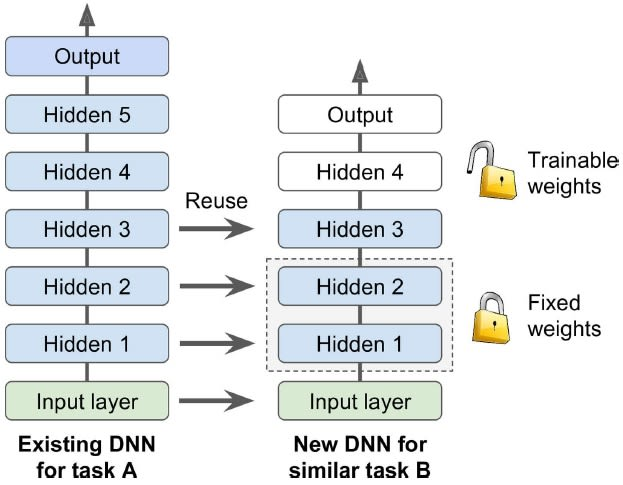

In [16]:
display.Image("https://www.simplilearn.com/ice9/free_resources_article_thumb/transfer-learning-using-pretrained-layers.jpg")

- The output layer of the original model should usually be replaced since it is most likely not useful at all for the new task, and it may not even have the right number of outputs for the new task. 
- Similarly, the upper hidden layers of the original model are less likely to be useful as the lower layers, since the high-level features that are most useful for the new task may differ significantly from the ones that were most useful for the original task. 
- Try freezing the reused layers first (make then untrainable, so gradient descent won't modify them)
- If you still cannot get good performance, and you have little training data, try dropping the top hidden layers(s) and freeze all remaining hidden layers again. If you have more training data, you may try replacing the top hidden layers instead of dropping them, and even add more hidden layers.

## Transfer learning using Keras


Suppose fashion MNIST dataset only contained 8 classes, all classes except for sandals and shirts. Someone built and trained a keras model on that set and got reasonably good performance (>90% accuracy). Let's call this **Model A**. 


You want to tackle a different task: You have images of sandals and shirts, and you want to train a binary classifier (positive = shirts, negative = sandals). However, your dataset is quite small, you only have 200 labeled images. When you train your new model, let's call this **Model B**.

With the same architecture as **A**, your architecture **B** performs reasonably well say (97.2% accuracy), but since it's a much easier task (there are just 2 class), you were hoping for more. 
Since task **B** is similar to **A**, **transfer learning** might help.


First, Let's create **Model A** for transfer learning.

In [34]:
# First let's create datasets
def split_dataset(X,y):
    y_5_or_6 = (y==5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 #class indices 7,8,9 should be moved to 5,6,7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # 1 for shirt, 0 for sandals
    
    return ((X[~y_5_or_6],y_A),
            (X[y_5_or_6],y_B))

(X_train_A,y_train_A),(X_train_B,y_train_B) = split_dataset(X_train,y_train)
(X_valid_A,y_valid_A),(X_valid_B,y_valid_B) = split_dataset(X_valid,y_valid)
(X_test_A,y_test_A),(X_test_B,y_test_B) = split_dataset(X_test,y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [35]:
y_train_A[:10]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4], dtype=uint8)

In [36]:
y_train_B[:10]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0.], dtype=float32)

In [37]:
tf.random.set_seed(42)
np.random.seed(42)

In [38]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape = [28,28]))
for n_hidden in(300,100,50,50,50):
    model_A.add(keras.layers.Dense(n_hidden,activation = "selu"))
model_A.add(keras.layers.Dense(8,activation = "softmax"))

model_A.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_17 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_18 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_19 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_20 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_21 (Dense)             (None, 8)                

In [39]:
model_A.compile(loss = "sparse_categorical_crossentropy",
               optimizer = "sgd",
               metrics = ["accuracy"],
               )

In [40]:
history = model_A.fit(X_train_A,y_train_A,epochs = 20,
                     validation_data = (X_valid_A,y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.3650 - accuracy: 0.8706 - val_loss: 0.2980 - val_accuracy: 0.8944
Epoch 2/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2661 - accuracy: 0.9071 - val_loss: 0.2587 - val_accuracy: 0.9076
Epoch 3/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2442 - accuracy: 0.9139 - val_loss: 0.2451 - val_accuracy: 0.9108
Epoch 4/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2285 - accuracy: 0.9188 - val_loss: 0.2343 - val_accuracy: 0.9185
Epoch 5/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2162 - accuracy: 0.9229 - val_loss: 0.2366 - val_accuracy: 0.9160
Epoch 6/20
1375/1375 [==============================] - 3s 3ms/step - loss: 0.2073 - accuracy: 0.9260 - val_loss: 0.2279 - val_accuracy: 0.9230
Epoch 7/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.1990 - accuracy: 0.9290 - val_loss: 0.2458 - val_accuracy:

In [41]:
model_A.save("model_A.h5")

Now let's create **Model_B** without **transfer learning**. 

In [42]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape = [28,28]))
for n_hidden in (300,100,50,50,50):
    model_B.add(keras.layers.Dense(n_hidden,activation = "selu"))
model_B.add(keras.layers.Dense(1,activation = "sigmoid"))

model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [43]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 0s 27ms/step - loss: 0.9573 - accuracy: 0.4650 - val_loss: 0.6314 - val_accuracy: 0.6004
Epoch 2/20
7/7 [==============================] - 0s 10ms/step - loss: 0.5692 - accuracy: 0.7450 - val_loss: 0.4784 - val_accuracy: 0.8529
Epoch 3/20
7/7 [==============================] - 0s 9ms/step - loss: 0.4503 - accuracy: 0.8650 - val_loss: 0.4102 - val_accuracy: 0.8945
Epoch 4/20
7/7 [==============================] - 0s 11ms/step - loss: 0.3879 - accuracy: 0.8950 - val_loss: 0.3647 - val_accuracy: 0.9178
Epoch 5/20
7/7 [==============================] - 0s 11ms/step - loss: 0.3435 - accuracy: 0.9250 - val_loss: 0.3300 - val_accuracy: 0.9320
Epoch 6/20
7/7 [==============================] - 0s 12ms/step - loss: 0.3081 - accuracy: 0.9300 - val_loss: 0.3019 - val_accuracy: 0.9402
Epoch 7/20
7/7 [==============================] - 0s 12ms/step - loss: 0.2800 - accuracy: 0.9350 - val_loss: 0.2804 - val_accuracy: 0.9422
Epoch 8/20
7/7 [============

Now let's use **Transfer learning**. Create **Model_B from Model_A**. Model_B copies all layers except output layer.

In [44]:
model_A = keras.models.load_model("model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1,activation = "sigmoid"))

Note that **model_A** and **model_B_on_A** now share some layers. When you train **model_B_on_A**, it will also affect **model_A**. If you want to avoid that, clone **model_A** before you reuse its layers.  

In [45]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [46]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False
    # making sure the weight doesn't get updated by gradient descent
    
model_B_on_A.compile(loss = "binary_crossentropy",
                    optimizer = keras.optimizers.SGD(lr = 1e-3),
                    metrics = ["accuracy"])

In [47]:
history = model_B_on_A.fit(X_train_B,y_train_B,epochs = 4,
                          validation_data = (X_valid_B,y_valid_B))

# train first few epochs so that randomly assigned weight of last layer
# is not affected by large gradient errors. 

Epoch 1/4
7/7 [==============================] - 0s 25ms/step - loss: 0.6995 - accuracy: 0.6450 - val_loss: 0.6882 - val_accuracy: 0.6684
Epoch 2/4
7/7 [==============================] - 0s 11ms/step - loss: 0.6567 - accuracy: 0.6800 - val_loss: 0.6461 - val_accuracy: 0.6917
Epoch 3/4
7/7 [==============================] - 0s 9ms/step - loss: 0.6143 - accuracy: 0.6850 - val_loss: 0.6116 - val_accuracy: 0.7039
Epoch 4/4
7/7 [==============================] - 0s 11ms/step - loss: 0.5796 - accuracy: 0.7100 - val_loss: 0.5783 - val_accuracy: 0.7241


In [51]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True # unfreeze the layers

optimizer = keras.optimizers.SGD(lr = 1e-3)
model_B_on_A.compile(loss = "binary_crossentropy",
                    optimizer = optimizer,
                    metrics = ["accuracy"])

history = model_B_on_A.fit(X_train_B,y_train_B,epochs = 16,
                          validation_data = (X_valid_B,y_valid_B))

Epoch 1/16
7/7 [==============================] - 0s 24ms/step - loss: 0.0592 - accuracy: 0.9950 - val_loss: 0.0837 - val_accuracy: 0.9777
Epoch 2/16
7/7 [==============================] - 0s 11ms/step - loss: 0.0563 - accuracy: 0.9950 - val_loss: 0.0802 - val_accuracy: 0.9777
Epoch 3/16
7/7 [==============================] - 0s 9ms/step - loss: 0.0536 - accuracy: 0.9950 - val_loss: 0.0771 - val_accuracy: 0.9807
Epoch 4/16
7/7 [==============================] - 0s 10ms/step - loss: 0.0511 - accuracy: 0.9950 - val_loss: 0.0743 - val_accuracy: 0.9807
Epoch 5/16
7/7 [==============================] - 0s 10ms/step - loss: 0.0489 - accuracy: 0.9950 - val_loss: 0.0717 - val_accuracy: 0.9817
Epoch 6/16
7/7 [==============================] - 0s 11ms/step - loss: 0.0467 - accuracy: 0.9950 - val_loss: 0.0694 - val_accuracy: 0.9838
Epoch 7/16
7/7 [==============================] - 0s 12ms/step - loss: 0.0449 - accuracy: 0.9950 - val_loss: 0.0671 - val_accuracy: 0.9848
Epoch 8/16
7/7 [============

In [52]:
model_B.evaluate(X_test_B,y_test_B)

63/63 [==============================] - 0s 1ms/step - loss: 0.1408 - accuracy: 0.9705


[0.1408407837152481, 0.9704999923706055]

In [55]:
model_B_on_A.evaluate(X_test_B,y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.0525 - accuracy: 0.9880


[0.05249428004026413, 0.9879999756813049]

The result from **model_B_on_A** looks significantly good compared to **model_B**. However, this is not quite true in this case because the result may fluctuate or worsen if seed value is changed or classes are changed. 

**Transfer learning** doesn't work very well with small dense networks: it works best with deep convolutional neural networks, so we will revisit Transfer learning. 

## Fast optimizers (Improve training time)

There are learning rate schedulings such as -

- Power scheduling 
- Exponential scheduling
- Piecewise constant scheduling

But we discuss some some optimization methods.

In [56]:
# Momentum optimization
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)
# Nestrerov Accelerated Gradient
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)
# AdaGrad
optimizer = keras.optimizers.Adagrad(lr=0.001)
# RMSProp
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)
# Adam Optimization
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
# Adamax Optimization
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)
# Nadam Optimization
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Avoiding Overfitting Through Regularization
With thousand, even millions of parameters, DNN has incredible amount of freedom and can fit a huge variety of complex datasets. But this great flexibility also means that it is prone to overfitting. 

We already implemented one of the best regularization technique in chapter 10 called **early stopping**. Moreover, Batch Normalization acts like a pretty good regularizer too even though it was designed to solve vanishing/exploding gradient problem.  In this section, we will discuss l1 and l2 regularization, dropout and max-norm regularization

## l1 and l2 Regularization.

A regression model that uses L1 regularization technique is called **Lasso Regression** and model which uses L2 is called **Ridge Regression**. 
The key difference is in penalty term. 

**Ridge Regression** adds "squared magnitude" of coefficent as penalty term to the loss function. 

$$Cost =  \sum_{i = 1} ^ n (y_i - \sum_{j = 1} ^ p x_{ij}\beta_j)^2 + \lambda \sum_{j = 1} ^ p \beta_j^2$$

Here :
- if lambda is 0, we get normal regression
- if lambda is large, it will add too much weight and it will lead to underfitting. 

**Lasso Regression** adds "absolute value of magnitude" of coefficent as penalty term to the loss function. 

$$Cost =  \sum_{i = 1} ^ n (y_i - \sum_{j = 1} ^ p x_{ij}\beta_j)^2 + \lambda \sum_{j = 1} ^ p |{\beta_j}|$$


So, We know gradient descent formula,
$$ W^{next step} = W - \eta\nabla(Cost)$$

So higher cost due to higher weights are penalized in weights.

Applying in keras:

In [58]:
# For l2 regularizer
layer = keras.layers.Dense(100,activation = "elu",
                          kernel_initializer = "he_normal",
                          kernel_regularizer = keras.regularizers.l2(0.01))

# if l1 regularizer then replace l2 by l1(0.1)
# or l1_l2(0.1,0.01) for both l1 and l2 regularization

## Dropout

In this, at every training step, every neuron (including input neurons, but always excluding the output neuron) has a probability p of being temporarily "dropped out", meaning it will be entirely ignored during this training step, but it may be active during the next step. 

The hyperparameter p is called the *dropout rate*, and typically it is 50%. 

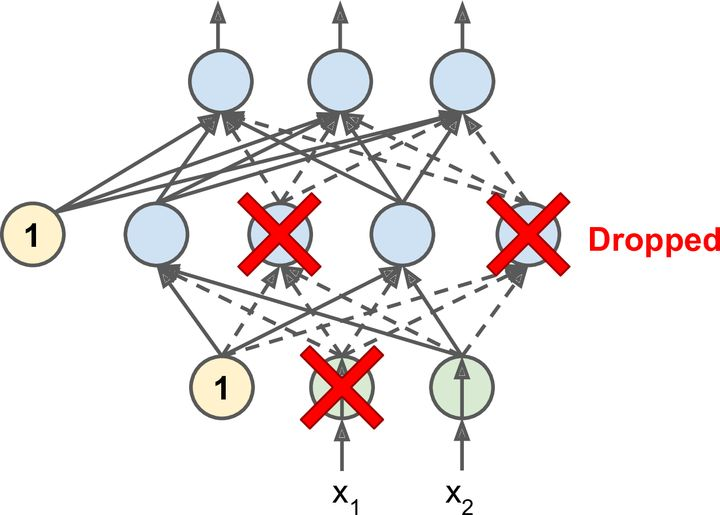

In [60]:
display.Image("https://pic3.zhimg.com/v2-84283f7b810b58204f1954c5ba47e2ce_b.jpg")

There is one detail. Suppose p = 50%, in which case during testing a neuron will be connected to twice as many input neurons as it was (on average) during training. To compensate for this fact, we need to multiply each neuron's input connection weights by 0.5 after training. 

More generally, we need to multiply each input connection weight by the *keep probability (1-p)* after training. 

Implementation using keras:

In [62]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28,28]),
    keras.layers.Dropout(rate = 0.2),
    keras.layers.Dense(300,activation = "elu",kernel_initializer = "he_normal"),
    keras.layers.Dropout(rate = 0.2),
    keras.layers.Dense(100,activation = "elu",kernel_initializer = "he_normal"),
    keras.layers.Dropout(rate = 0.2),
    keras.layers.Dense(10,activation = "softmax")
])

model.compile(loss = "sparse_categorical_crossentropy",
             optimizer = "nadam",
             metrics = ["accuracy"])
history = model.fit(X_train,y_train,epochs = 2,
                   validation_data = (X_valid,y_valid))

Epoch 1/2
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5736 - accuracy: 0.7906 - val_loss: 0.4162 - val_accuracy: 0.8494
Epoch 2/2
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4537 - accuracy: 0.8323 - val_loss: 0.3549 - val_accuracy: 0.8660


## Max Norm Regularization
In this, for each neuron, it constrains the weight **w** of the incoming connections such that ||w|| < r, where r is the max_norm hyperparameter. 

Reducing r increases the amount of regularization and helps reduce overfitting. 

In [63]:
layer = keras.layers.Dense(100,activation = "relu",kernel_initializer = "he_normal",
                          kernel_constraint = keras.constraints.max_norm(1.))